In [1]:
import numpy as np
import stat as st
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import scipy.stats as scs
import matplotlib.pyplot as plt
import math
from pandas.tools.plotting import autocorrelation_plot
from pandas import read_csv, DataFrame
from sklearn.metrics import r2_score
import datetime
import copy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Функции

In [2]:
df = pd.read_csv('gold_day.csv', sep=';', keep_default_na=False)
data = df.cost

In [3]:
def stat(x):
    _x = x  # Для возможности предобработки данных (например, исключения нечисловых значений) 
    print('счет', len(x))
    print('среднее', (np.mean(_x)))
    print('минимальное', np.min(_x), 'и максимальное', np.max(_x))
    print('стандартное отклонение', pd.core.groupby.GroupBy.std(_x))
    print('дисперсия', np.var(_x))
    print('коэффициент вариации', (np.std(_x)) / (np.mean(_x)))
    print('коэффициент асимметрии', scs.skew(_x))  # асимметрия 
    print('эксцесс', scs.kurtosis(_x)) # эксцесс
    _range = np.linspace(0.9 * np.min(_x), 1.1 * np.max(_x), 12)
    print('квантили 25%, 50%, 75%', np.percentile(_x, 25), np.percentile(_x, 50), np.percentile(_x, 75))
    print('оценка плотности распределения:')
    plotnost = scs.gaussian_kde(_x)(_range)
    print(plotnost) # оценка плотности распределения


def plotMovingAverage(series, n):
    rolling_mean = series.rolling(window=n).mean()#параметры скользящего среднего

    plt.figure(figsize=(15,5))#размер
    plt.title("Moving average\n window size = {}".format(n))#заголовок
    plt.plot(rolling_mean, "r-", label="Rolling mean trend")#скол. среднее, цвет, подпись линии

    plt.plot(df.cost[n:], "k", label="Actual values")#значения [n:],начиная с н до конца
    plt.legend(loc="upper left")#где расположить легенду, тут сверху слева
    plt.grid(True)#сетка на графике


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return


def autocor(y, lags=None, figsize=(12, 7), style='bmh'):
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)#размер
        layout = (2, 1)
        acf_ax = plt.subplot2grid(layout, (1, 0))

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return


def student(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    # Критерий Стьюдента для двух выборок
    # Нулевая гипотеза: мат ожидания для двух групп равны
    # Причём должно выполнится предположение о равной дисперсии
    # (способы проверки которого приведены ниже)
    # Это верно для независимых групп: например, результаты экзамена для мальчиков и девочек
    # И для зависимых групп: например, как один и тот же класс сдал 2 разных экзамена.
    t_statistic, p_value = scs.ttest_ind(group1, group2)
 
    # p_value &lt; 0.05 =&gt; альтернативная гипотеза:
    # с 5% вероятностью ошибки первого рода у нас будет разное мат. ожидание
    # тест с 2 хвостами, двухпарный
    print("two-sample t-test:")
    print('p_value =', p_value)
    print('t_statistic =', t_statistic)


def student2(data):
    r = 0
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) != np.var(group2):
        t = (abs(np.mean(group1) - np.mean(group2))) / math.sqrt(
            (np.var(group1) / len(group1) + np.var(group2) / len(group2)))
        print('дисперсии не равны')
        print('критерий Стьюдента =', t)
    else:
        t = ((abs(np.mean(group1) - np.mean(group2))) / np.var(group2)) * (math.sqrt(
            (len(group1) * len(group2)) / (len(group1) + len(group2))))
        print('дисперсии равны')
        print('критерий Стьюдента =', t)


def mann2(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    # Если данные не распределены нормально, применяем критерий Манна-Уитни, также известный как 
    # Критерий Уилкоксона для двух выборок
    u, p_value = scs.mannwhitneyu(group1, group2, alternative='two-sided')
    g1 = len(group1)
    g2 = len(group2)
    print('two-sample wilcoxon-test(mann-whitneyu), p_value =', p_value)
    print('U =', u)
    print('M(U) =', g1 * g2 / 2)
    print('D(U) =', g1 * g2 * (g1 + g2 + 1) / 12)
    if (u - (g1 * g2 / 2)) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12) > 0:
        z = (u - (g1 * g2 / 2) - 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    else:
        z = (u - (g1 * g2 / 2) + 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    print('Z =', z)


def test_ks(data):
    group1 = data[:int(len(data) // 2)]
    group2 = data[int(len(data) // 2):]
    
    ks_statistic, p_value = scs.ks_2samp(group1, group2)
    print('two-sample ks-test')
    print('p_value =', p_value)
    print('ks_statistic =', ks_statistic)


def normal(x):
    print('normaltest teststat = %f p_value = %f' % scs.normaltest(x))


def fisher(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) >= np.var(group2):
        f = np.var(group1) / np.var(group2)
    else:
        f = np.var(group2) / np.var(group1)
    print('критерий Фишера =', f)


def acf_and_pacf(data, lags=None):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()


def mann(x):
    x = list(x)
    s = [0] * len(x)
    for i in range(len(x)):
        s[i] = i + 1
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    u1 = r1 - (t1 * (t1 + 1)) / 2
    u2 = t1 * t2 - (t2 * ( t2 + 1)) / 2 - r2
    mu = (t1 * t2) / 2
    du = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (u1 - (t1 * t2) / 2) / (sqrt(du))
    if z > 0:
        z = (u1 - (t1 * t2) / 2 - 1 / 2) / (sqrt(du))
    else:
        z = (u1 - (t1 * t2) / 2 + 1 / 2) / (sqrt(du))
    print('U =', u1)
    print('M(U) =', mu)
    print('D(U) =', du)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве мат. ожидания принимается')
    else:
        print('гипотеза о постоянстве постоянстве мат. ожидания не принимается')


def sijel(x):
    x = list(x)
    sr = np.mean(x)
    s = [0] * len(x)
    for i in range(int(len(x) / 2)):
        s[i] = 2 * i + 1
        s[-i - 1] = 2 * i + 2
    if s[int(len(x) / 2)] == 0:
        s[int(len(x) / 2)] = 2 * (int(len(x) / 2) + 1)
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        x[i] = x[i] - sr
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    mw = r1 - t1* (t1 + t2 + 1) / 2
    dw = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (r1 - (t1 * ( t1 + t2 + 1)) / 2) / (sqrt(dw))
    if z > 0:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 - 1 / 2) / (sqrt(dw))
    else:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 + 1 / 2) / (sqrt(dw))
    print('M(U) =', mw)
    print('D(U) =', dw)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве дисперсии принимается')
    else:
        print('гипотеза о постоянстве постоянстве дисперсии не принимается')



# Решение

In [4]:
stat(data)

счет 1504
среднее 1259.98866356
минимальное 1050.7 и максимальное 1614.3
стандартное отклонение 88.2932984794
дисперсия 7790.52324084
коэффициент вариации 0.0700513769098
коэффициент асимметрии 0.7248922758070075
эксцесс 2.6484799187750054
квантили 25%, 50%, 75% 1209.6 1259.2 1310.32
оценка плотности распределения:
[  5.22720830e-11   3.84926872e-05   9.64531403e-04   2.23443565e-03
   5.25793021e-03   3.95621815e-03   5.80163381e-04   1.49375577e-04
   1.17660947e-04   1.11798045e-04   4.94413127e-09   6.33459333e-19]


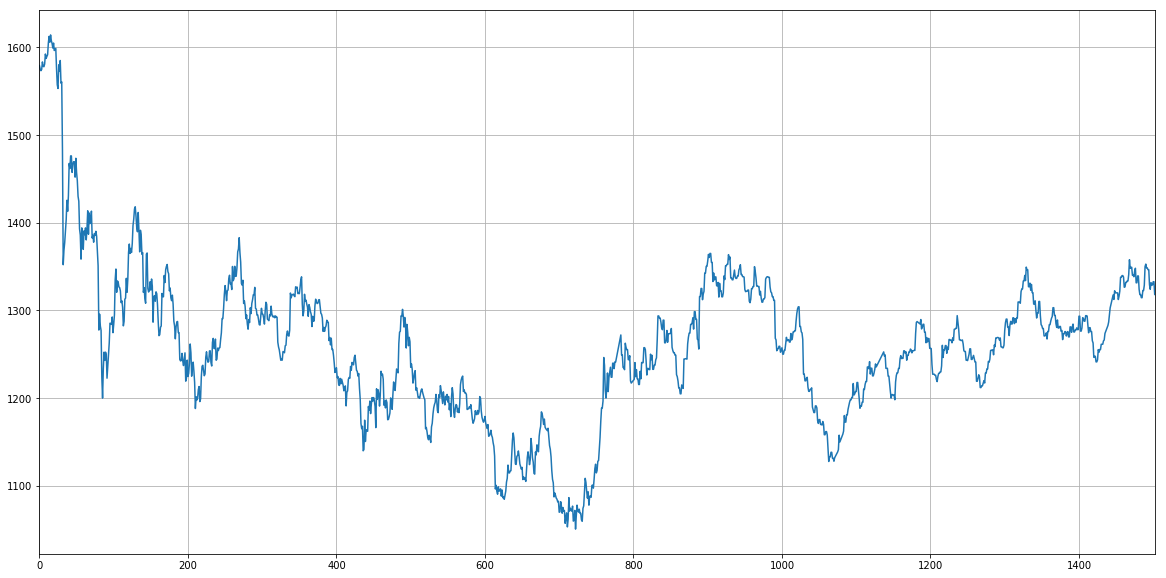

In [5]:
data.plot(figsize=(20, 10), grid=True)
plt.show()

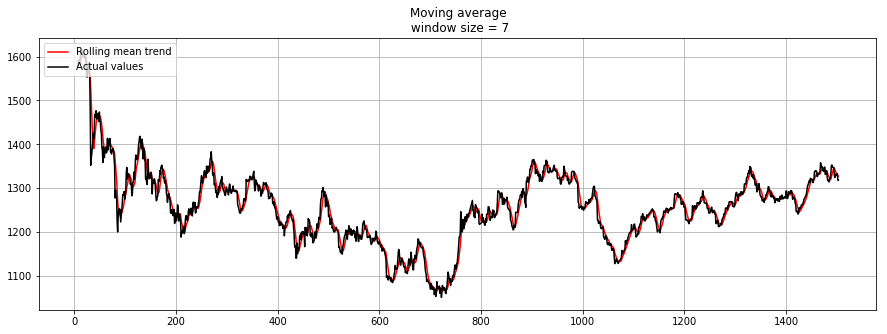

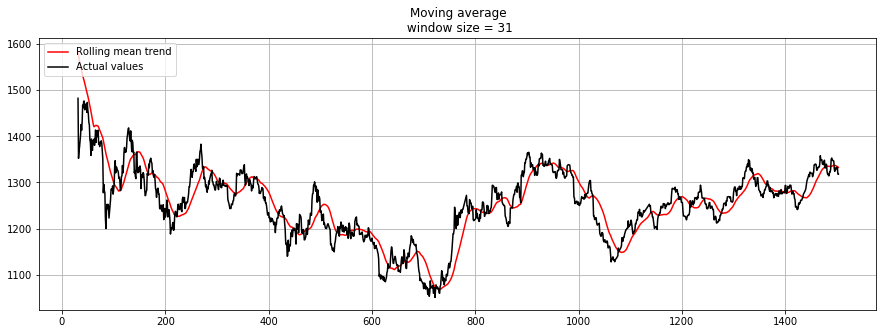

In [6]:
plotMovingAverage(data, 7)#скользяшее среднее по неделе
plotMovingAverage(data, 31)#скользяшее среднее по месяцу
plt.show()

# Нормальность Исходных данных

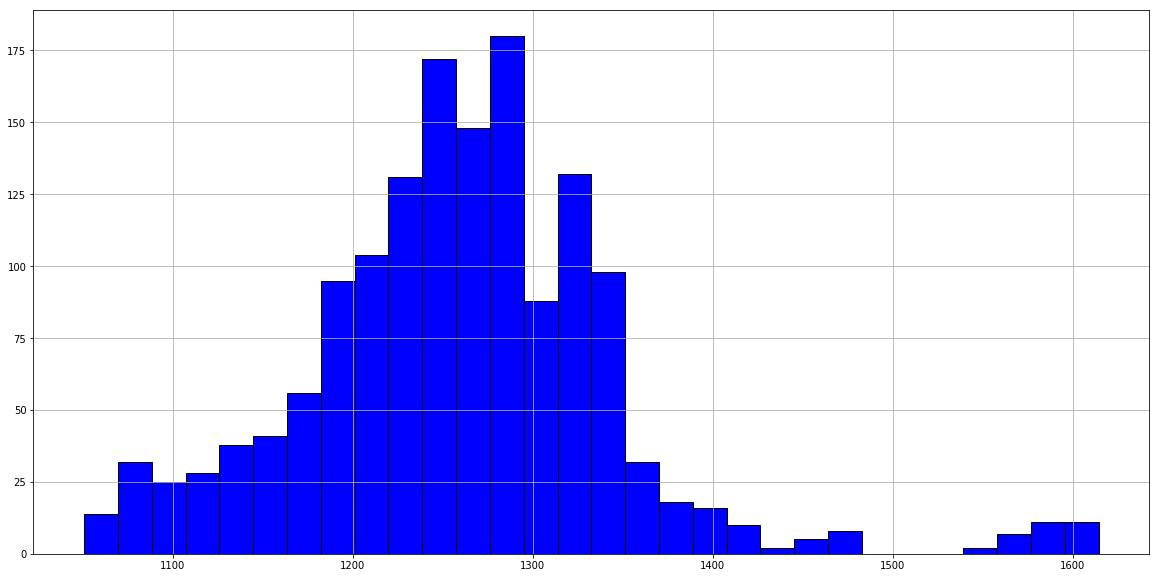

In [7]:
data.hist(figsize=(20, 10), bins=30, color="blue", edgecolor='black')
plt.show()

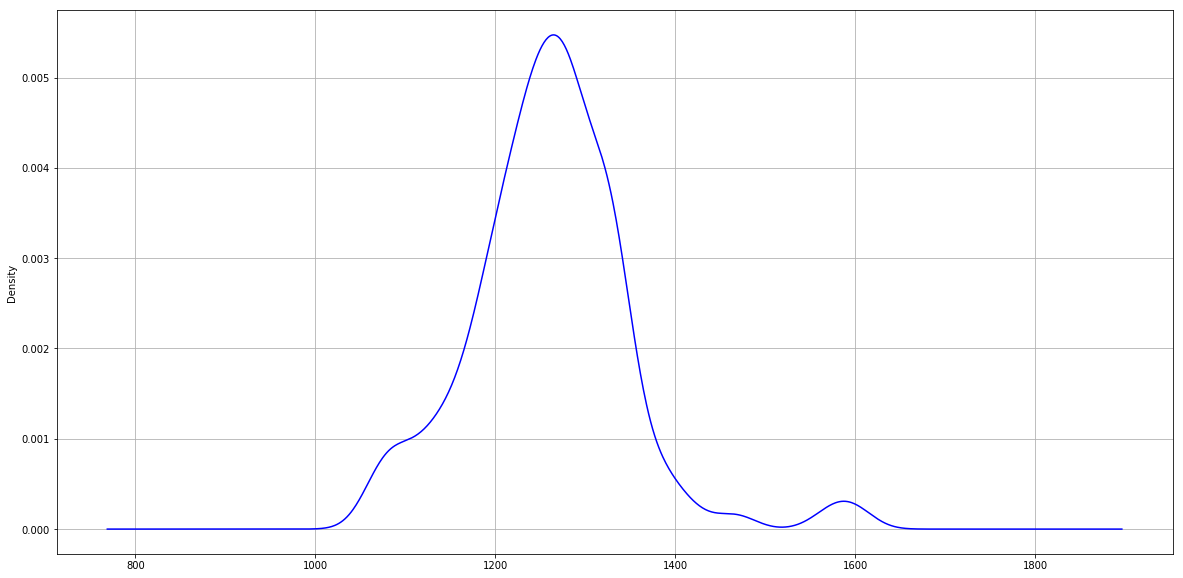

In [8]:
data.plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

# Стационарность исходных данных

In [9]:
mann(data)

Группа 1 и 2: 752 и 752
сумма рангов r1 = 524437
сумма рангов r2 = 607323
U = 241309.0
M(U) = 282752.0
D(U) = 70923626.66666667
Z = -4.920967294
гипотеза о постоянстве постоянстве мат. ожидания не принимается


In [10]:
sijel(data)

Группа 1 и 2: 752 и 752
сумма рангов r1 = 444187
сумма рангов r2 = 687573
M(U) = -121693.0
D(U) = 70923626.66666667
Z = -14.4500165874
гипотеза о постоянстве постоянстве дисперсии не принимается


In [11]:
test = sm.tsa.adfuller(data)# тест Фуллера
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -4.40204833389
p-value:  0.00029436475761
Critical values:  {'1%': -3.4347731400734789, '5%': -2.8634935294626773, '10%': -2.5678100382791524}
единичных корней нет, ряд стационарен


# Первые разности

In [12]:
dataR1 = data - data.shift(1)
dataR2 = dataR1 - dataR1.shift(1)
dataR3 = dataR2 - dataR2.shift(1)

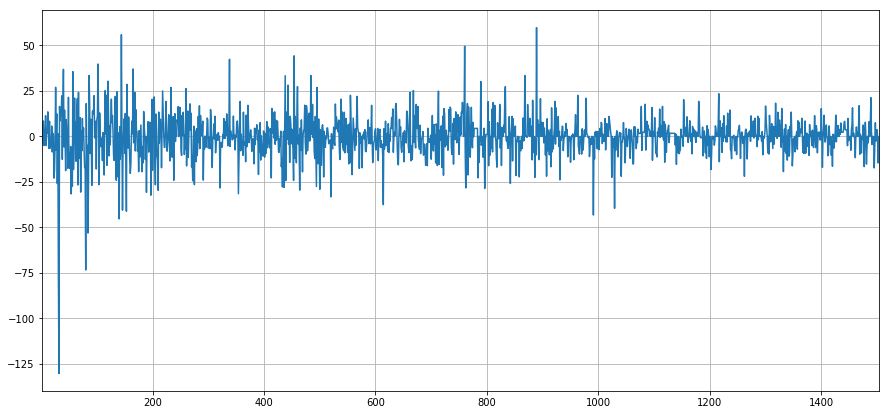

In [13]:
dataR1[1:].plot(figsize=(15,7))
plt.grid()
plt.show()

In [14]:
stat(dataR1[1:])

счет 1503
среднее -0.173918829009
минимальное -130.3 и максимальное 59.83
стандартное отклонение 11.5050288167
дисперсия 132.277620417
коэффициент вариации -66.1297048201
коэффициент асимметрии -1.2280608722352997
эксцесс 15.155309440591427
квантили 25%, 50%, 75% -5.05 0.0 4.5
оценка плотности распределения:
[  6.34846054e-10   4.04907474e-20   9.48418228e-06   7.50560692e-06
   8.12335163e-05   5.89477537e-04   6.51613791e-03   5.55418228e-02
   8.65499304e-03   7.59992082e-04   1.25379624e-04   8.09606053e-06]


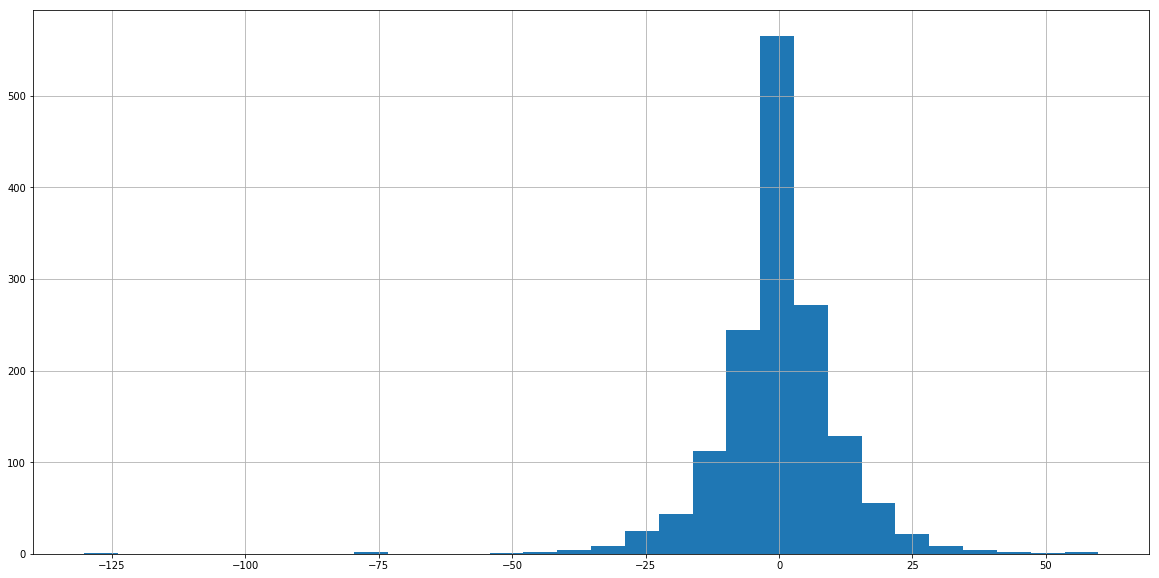

In [15]:
dataR1.hist(figsize=(20,10), bins=30)
plt.show()

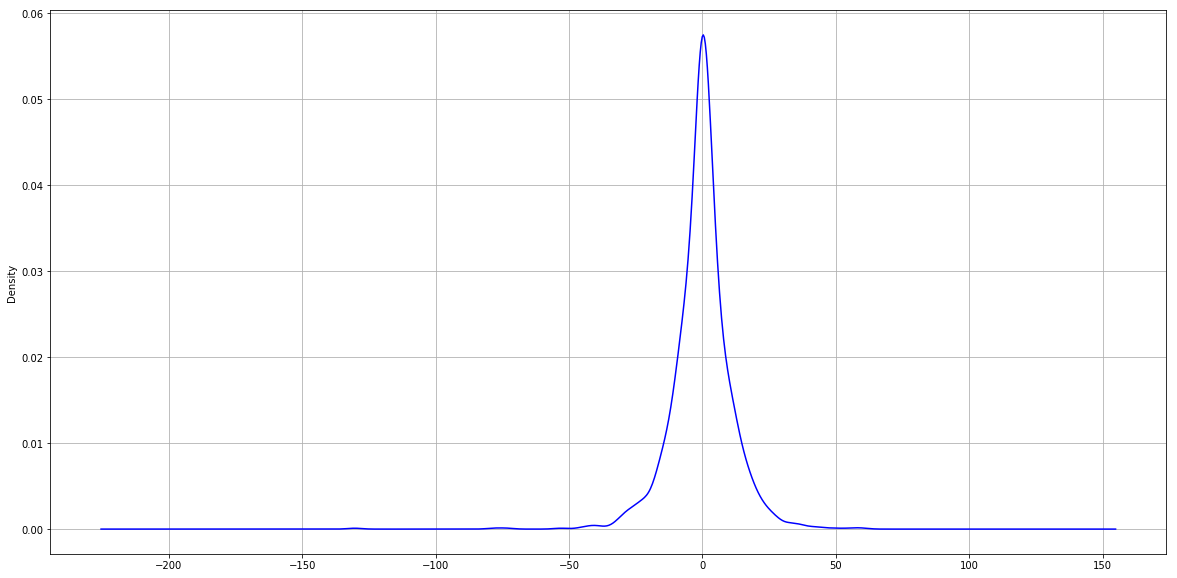

In [16]:
dataR1.plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

# Стационарность первых разностей

In [17]:
mann(dataR1[1:])

Группа 1 и 2: 751 и 752
сумма рангов r1 = 551951
сумма рангов r2 = 578305
U = 269575.0
M(U) = 282376.0
D(U) = 70782250.66666667
Z = -1.52147475255
гипотеза о постоянстве постоянстве мат. ожидания принимается


In [18]:
mann2(dataR1[1:])

two-sample wilcoxon-test(mann-whitneyu), p_value = 0.142676050917
U = 270056.5
M(U) = 282376.0
D(U) = 70782250.66666667
Z = -1.46424338711


In [19]:
sijel(dataR1[1:])

Группа 1 и 2: 751 и 752
сумма рангов r1 = 465698
сумма рангов r2 = 664559
M(U) = -99054.0
D(U) = 70782250.66666667
Z = -11.7735556737
гипотеза о постоянстве постоянстве дисперсии не принимается


In [20]:
student(dataR1[1:])
fisher(dataR1[1:])

two-sample t-test:
p_value = 0.137468253955
t_statistic = -1.4860788957
критерий Фишера = 2.65880865708


In [21]:
#тест Колмогорова-Смирнова
test_ks(dataR1[1:])

two-sample ks-test
p_value = 5.73316449112e-12
ks_statistic = 0.186848386548


In [22]:
#тест нормальности распределения
normal(dataR1[1:])

normaltest teststat = 581.635630 p_value = 0.000000


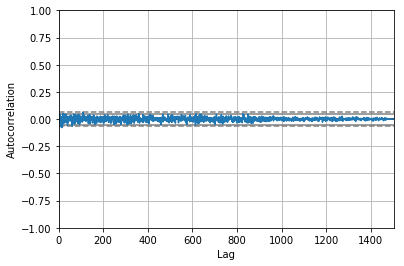

In [23]:
autocorrelation_plot(dataR1[1:])
plt.show()

In [24]:
#тест Харки — Бера
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dataR1[1:])
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

      JB      p-value      skew         kurtosis  
--------------------------------------------------
14761.7106338   0.0   -1.22806087224 18.1553094406
--------------------------------------------------


In [25]:
#обобщенный тест Дикки-Фуллера
test = sm.tsa.adfuller(dataR1[1:])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -8.53788572844
p-value:  9.96511233696e-14
Critical values:  {'1%': -3.4347761338892191, '5%': -2.8634948507368767, '10%': -2.5678107418736302}
единичных корней нет, ряд стационарен


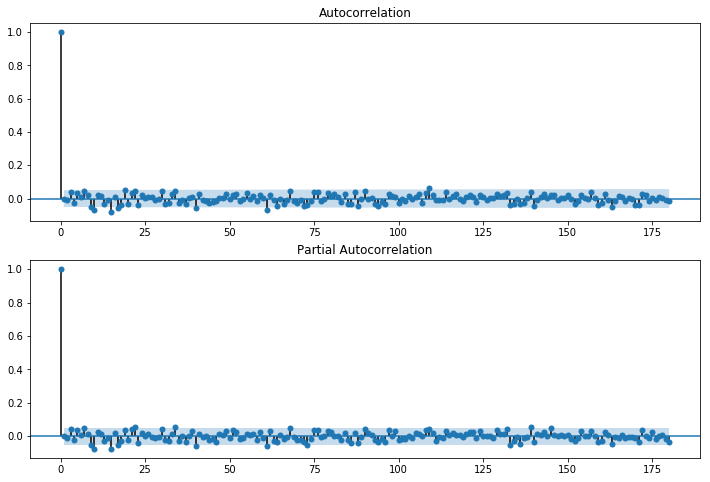

In [26]:
acf_and_pacf(dataR1[1:], lags=180)

# Вторые разности

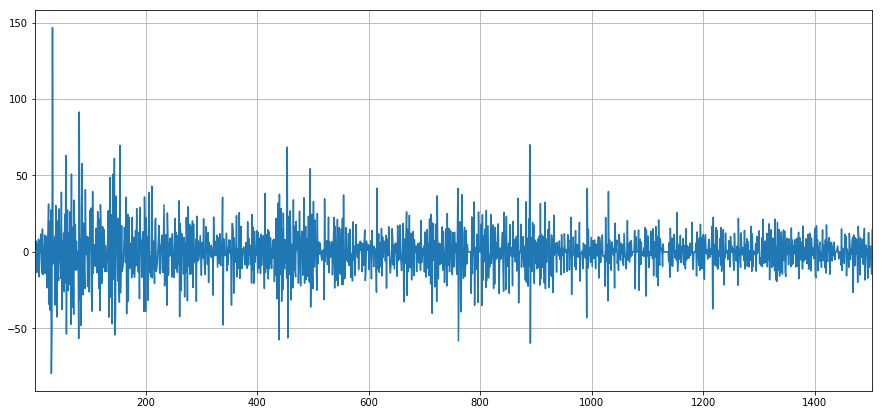

In [27]:
dataR2[2:].plot(figsize=(15,7))
plt.grid()
plt.show()

In [28]:
stat(dataR2[2:])

счет 1502
среднее 0.00239680426099
минимальное -79.7 и максимальное 146.8
стандартное отклонение 16.2778895231
дисперсия 264.793276085
коэффициент вариации 6789.23604552
коэффициент асимметрии 0.543617447026525
эксцесс 6.674305657566608
квантили 25%, 50%, 75% -9.0 -1.13686837722e-13 8.4
оценка плотности распределения:
[  8.27214814e-06   4.77687997e-04   3.10215446e-03   2.25674983e-02
   1.64187646e-02   2.01957673e-03   2.39789474e-04   3.47225159e-05
   1.68421446e-05   2.94094970e-16   1.57791002e-05   3.58360606e-08]


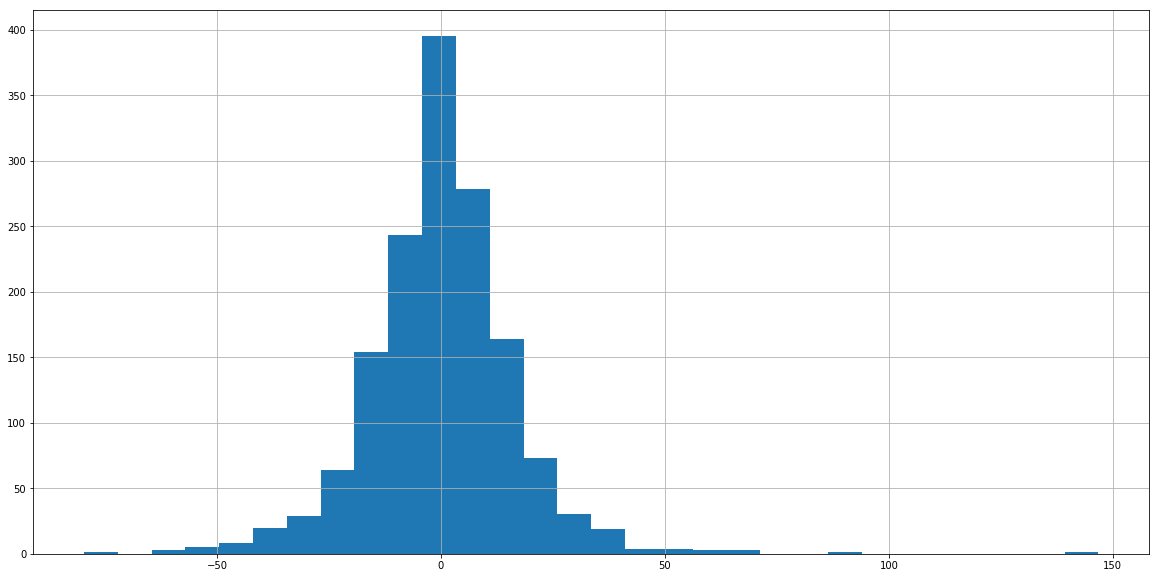

In [29]:
dataR2[2:].hist(figsize=(20,10), bins=30)
plt.show()

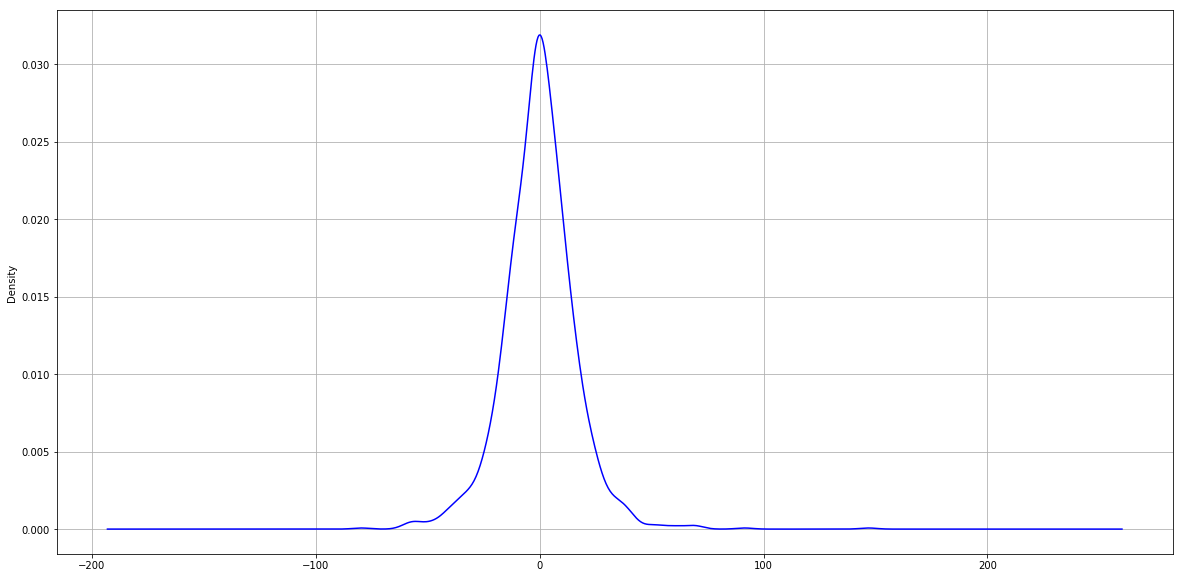

In [30]:
dataR2[2:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

# Стационарность вторых разностей

In [31]:
mann(dataR2[2:])

Группа 1 и 2: 751 и 751
сумма рангов r1 = 561287
сумма рангов r2 = 567466
U = 278911.0
M(U) = 282000.5
D(U) = 70641125.25
Z = -0.367526876809
гипотеза о постоянстве постоянстве мат. ожидания принимается


In [32]:
mann2(dataR2[2:])

two-sample wilcoxon-test(mann-whitneyu), p_value = 0.730779665182
U = 279108.0
M(U) = 282000.5
D(U) = 70641125.25
Z = -0.344087966246


In [33]:
sijel(dataR2[2:])

Группа 1 и 2: 751 и 751
сумма рангов r1 = 480851
сумма рангов r2 = 647902
M(U) = -83525.5
D(U) = 70641125.25
Z = -9.93774114131
гипотеза о постоянстве постоянстве дисперсии не принимается


In [34]:
student(dataR2[2:])
fisher(dataR2[2:])

two-sample t-test:
p_value = 0.967647270688
t_statistic = 0.040566022199
критерий Фишера = 2.59110994023


In [35]:
#тест Колмогорова-Смирнова
test_ks(dataR2[2:])

two-sample ks-test
p_value = 6.15331635891e-06
ks_statistic = 0.129161118509


In [36]:
#тест нормальности распределения
normal(dataR2[2:])

normaltest teststat = 278.415266 p_value = 0.000000


In [37]:
#тест Харки — Бера
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dataR2[2:])
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

      JB      p-value      skew         kurtosis  
--------------------------------------------------
2861.83793582   0.0   0.543617447027 9.67430565757
--------------------------------------------------


In [38]:
#обобщенный тест Дикки-Фуллера
test = sm.tsa.adfuller(dataR2[2:])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -14.007505495
p-value:  3.76509253563e-26
Critical values:  {'1%': -3.434785139702456, '5%': -2.8634988253050979, '10%': -2.5678128583805213}
единичных корней нет, ряд стационарен


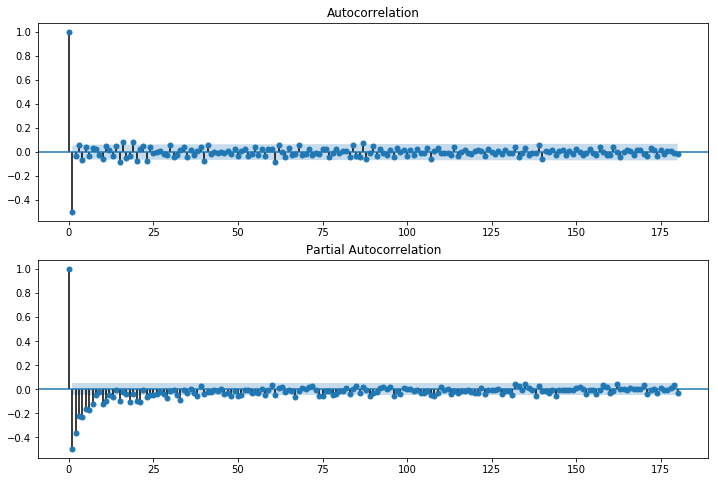

In [39]:
acf_and_pacf(dataR2[2:], lags=180)

# Доходность

In [40]:
dataR3 = data / data.shift(1)

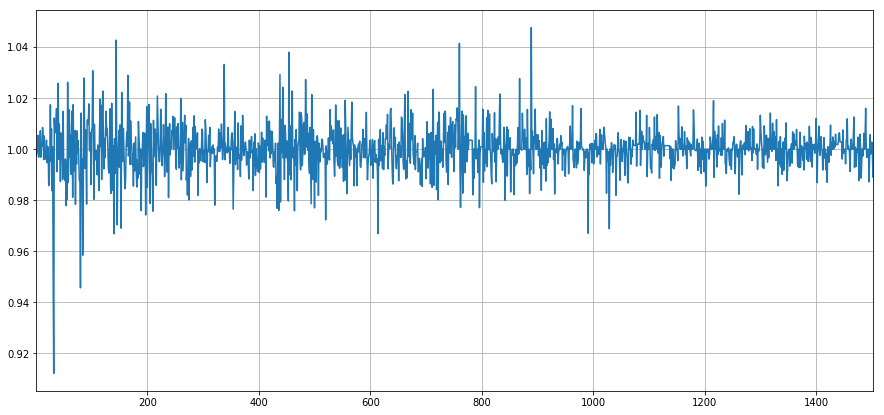

In [41]:
dataR3[1:].plot(figsize=(15,7))
plt.grid()
plt.show()

In [42]:
stat(dataR3[1:])

счет 1503
среднее 0.999919833794
минимальное 0.912107925801 и максимальное 1.04763383332
стандартное отклонение 0.00894904264693
дисперсия 8.0032080621e-05
коэффициент вариации 0.00894678232108
коэффициент асимметрии -0.729430569150989
эксцесс 9.805183282104576
квантили 25%, 50%, 75% 0.99598674348 1.0 1.00366791026
оценка плотности распределения:
[  0.00000000e+000   2.73712604e-190   4.93859838e-050   1.18866273e-001
   1.59527459e-002   5.20333013e-001   6.59143360e+001   3.76414254e-001
   4.84914359e-012   9.71139371e-102   2.59444282e-283   0.00000000e+000]


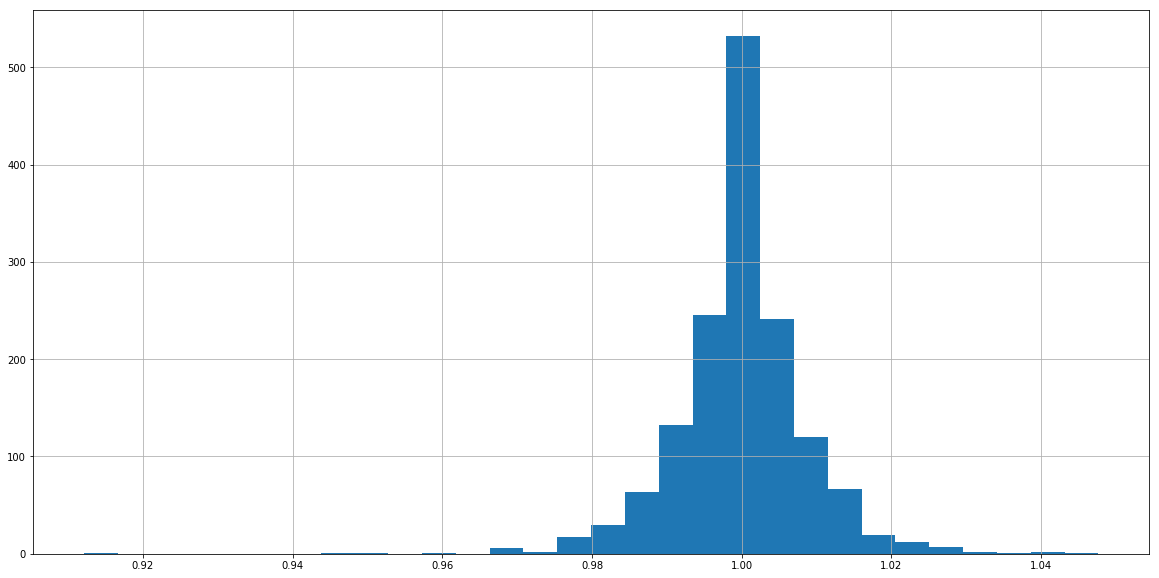

In [43]:
dataR3[1:].hist(figsize=(20,10), bins=30)
plt.show()

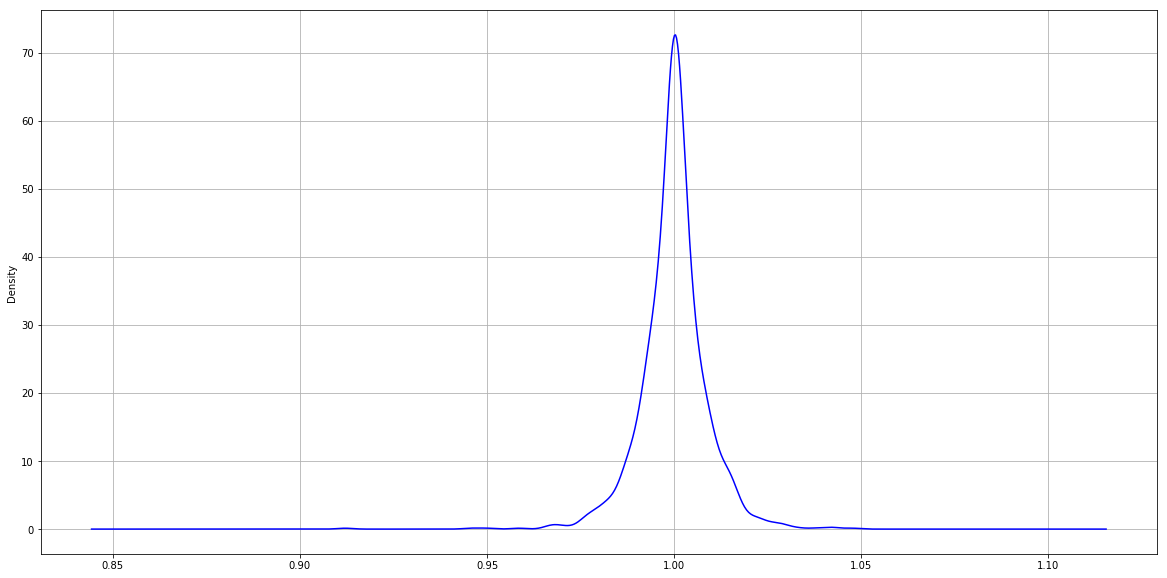

In [44]:
dataR3[1:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

# Стационарность доходности

In [45]:
mann(dataR3[1:])

Группа 1 и 2: 751 и 752
сумма рангов r1 = 552106
сумма рангов r2 = 578150
U = 269730.0
M(U) = 282376.0
D(U) = 70782250.66666667
Z = -1.50305136388
гипотеза о постоянстве постоянстве мат. ожидания принимается


In [46]:
mann2(dataR3[1:])

two-sample wilcoxon-test(mann-whitneyu), p_value = 0.138462071693
U = 269925.0
M(U) = 282376.0
D(U) = 70782250.66666667
Z = -1.47987355233


In [47]:
sijel(dataR3[1:])

Группа 1 и 2: 751 и 752
сумма рангов r1 = 463984
сумма рангов r2 = 666273
M(U) = -100768.0
D(U) = 70782250.66666667
Z = -11.9772826942
гипотеза о постоянстве постоянстве дисперсии не принимается


In [48]:
student(dataR3[1:])
fisher(dataR3[1:])

two-sample t-test:
p_value = 0.162361741987
t_statistic = -1.39785969064
критерий Фишера = 2.51412323405


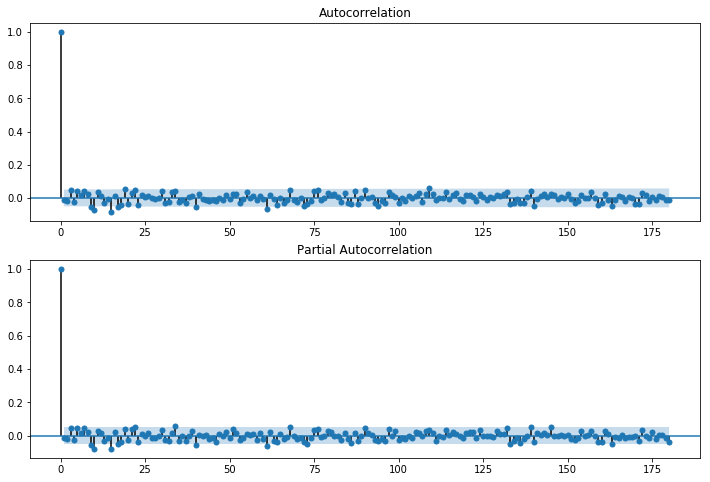

In [49]:
acf_and_pacf(dataR3[1:], lags=180)

# Сокращение выборки

In [50]:
dataR4 = data[301:] - data[301:].shift()
dataR4 = dataR4 - dataR4.shift()

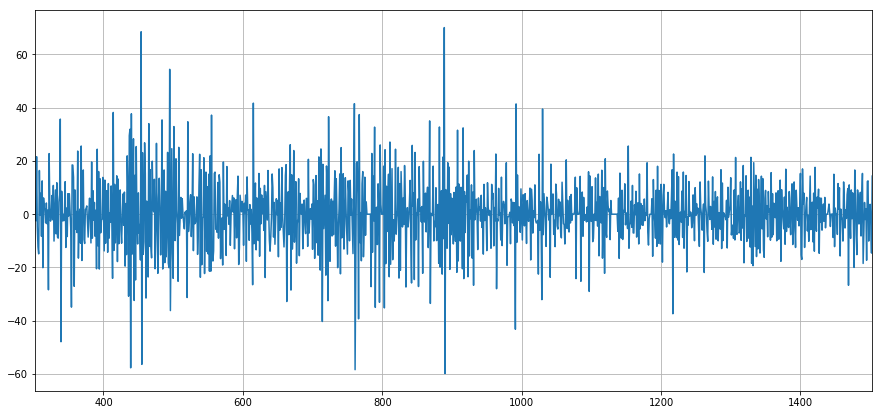

In [51]:
dataR4[1:].plot(figsize=(15,7))
plt.grid()
plt.show()

In [52]:
stat(dataR4[2:])

счет 1201
среднее 0.00341382181515
минимальное -59.83 и максимальное 70.07
стандартное отклонение 13.4191369976
дисперсия 179.923301674
коэффициент вариации 3929.1884313
коэффициент асимметрии 0.03271466644494784
эксцесс 2.5628844511124154
квантили 25%, 50%, 75% -7.7 0.0 7.6
оценка плотности распределения:
[  2.02414842e-04   3.82501255e-04   2.10283170e-03   9.48740106e-03
   2.70196151e-02   2.84399291e-02   1.06596345e-02   1.80665833e-03
   7.29226622e-04   9.67259170e-05   9.38439603e-05   1.31352964e-05]


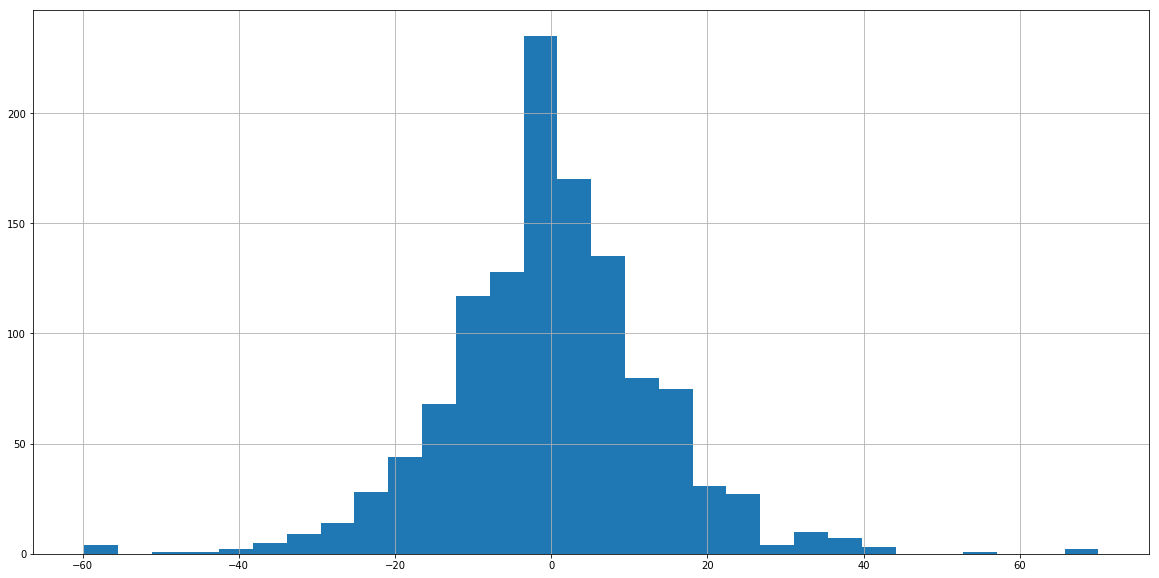

In [53]:
dataR4[2:].hist(figsize=(20,10), bins=30)
plt.show()

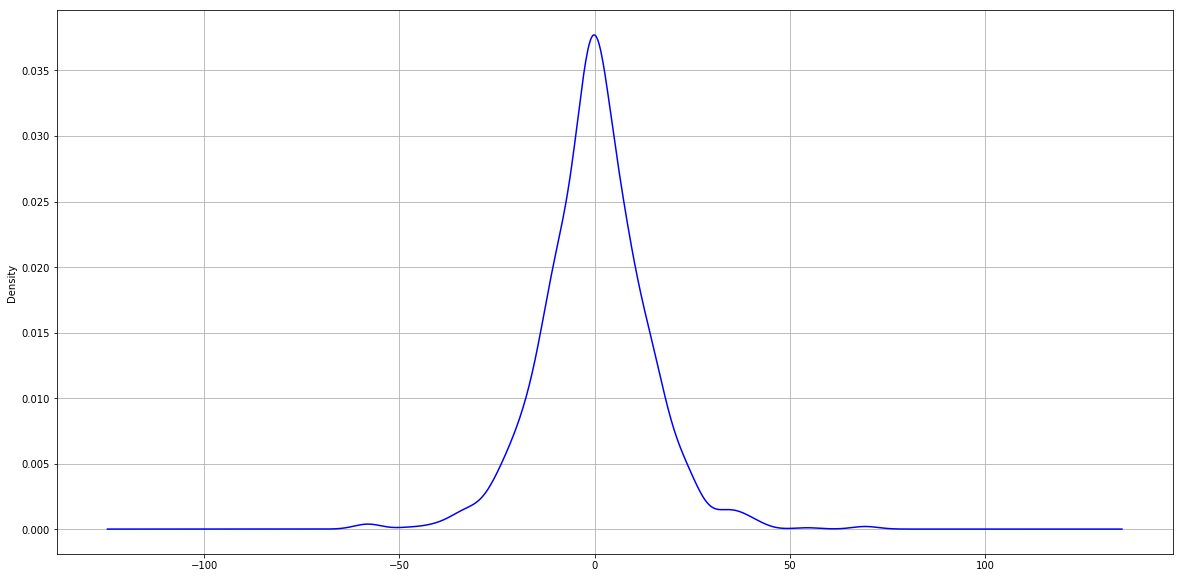

In [54]:
dataR4[2:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [55]:
mann(dataR4[1:])

Группа 1 и 2: 601 и 601
сумма рангов r1 = 359926
сумма рангов r2 = 363077
U = 179025.0
M(U) = 180600.5
D(U) = 36210400.25
Z = -0.261736261852
гипотеза о постоянстве постоянстве мат. ожидания принимается


In [56]:
mann2(dataR4[1:])

two-sample wilcoxon-test(mann-whitneyu), p_value = 0.892330862079
U = 179785.5
M(U) = 180600.5
D(U) = 36210400.25
Z = -0.135355038272


In [57]:
sijel(dataR4[1:])

Группа 1 и 2: 601 и 601
сумма рангов r1 = 361201
сумма рангов r2 = 361802
M(U) = -300.5
D(U) = 36210400.25
Z = -0.0498545260671
гипотеза о постоянстве постоянстве дисперсии принимается


In [58]:
fisher(dataR4[2:])

критерий Фишера = 2.43881963694


In [59]:
student(dataR4[2:])

two-sample t-test:
p_value = 0.99595932418
t_statistic = -0.00506531384751


In [60]:
student2(dataR4[2:])

дисперсии не равны
критерий Стьюдента = 0.00506777088198


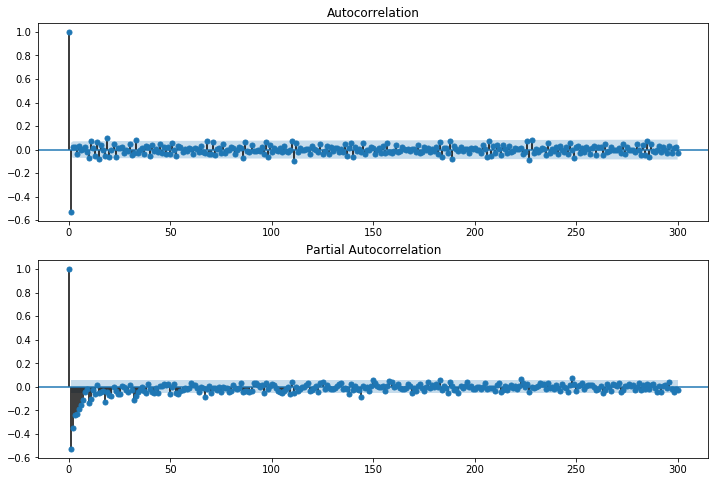

In [61]:
acf_and_pacf(dataR4[2:], lags=len(dataR4[2:]) / 4)

# ARIMA

In [66]:
src_data_model = np.array(dataR4[2:])
model = sm.tsa.ARIMA(src_data_model, order=(1,2,0), freq='W').fit(disp=0)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1199
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -5702.197
Method:                       css-mle   S.D. of innovations             28.121
Date:                Tue, 26 Jun 2018   AIC                          11410.393
Time:                        14:36:36   BIC                          11425.661
Sample:                             2   HQIC                         11416.145
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.463      0.017      0.986      -0.899       0.914
ar.L1.D2.y    -0.7562      0.019    -40.041      0.000      -0.793      -0.719
                                    Roots           

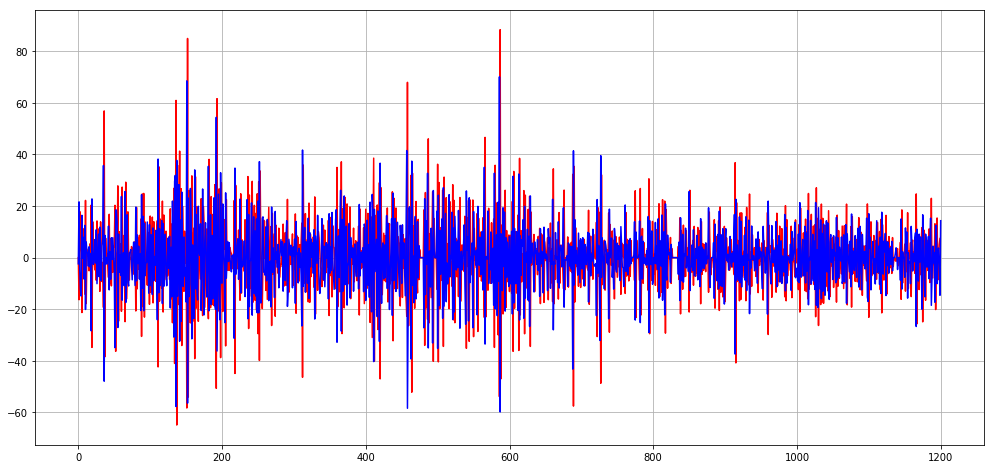

In [63]:
plt.figure(figsize=(17,8))
plt.grid()
plt.plot(1*model.fittedvalues, color="red")#прогноз
plt.plot(src_data_model, color="blue")#факт

In [64]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #resid - остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

        Q-stat       p-value
0   151.746448  7.198499e-35
1   295.267130  7.648167e-65
2   355.983454  7.551705e-77
3   358.654565  2.372533e-76
4   359.097861  1.923763e-75
5   359.105263  1.711883e-74
6   359.108519  1.382115e-73
7   362.371971  2.067090e-73
8   365.501789  3.101061e-73
9   374.671926  2.294145e-74
10  388.479119  1.704591e-76
11  388.816743  8.813869e-76
12  392.054589  1.064740e-75
13  394.548126  1.783996e-75
14  399.735264  7.862625e-76
15  402.043043  1.358446e-75
16  402.083225  6.801635e-75
17  405.613469  6.175621e-75
18  418.743140  5.497671e-77
19  423.451748  2.751657e-77
20  423.772782  1.102489e-76
21  430.019204  2.558075e-77
22  435.748457  7.505966e-78
23  435.976229  2.971303e-77
24  439.112379  2.902425e-77
25  439.468006  1.040963e-76
26  440.680979  2.444141e-76
27  441.741286  6.064956e-76
28  442.135534  2.024628e-75
29  447.207149  7.420593e-76
30  454.312190  1.041690e-76
31  456.043020  1.795000e-76
32  468.562720  1.987257e-78
33  469.270680

In [65]:
print(r2_score(src_data_model[:428], 1 * model.fittedvalues))

ValueError: Found input variables with inconsistent numbers of samples: [428, 1200]